**Baseline Condition**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1. Preprocessing (Required for SVM performance > 80%)
df = pd.read_csv('heart.csv')
df_encoded = pd.get_dummies(df, drop_first=True) # Convert categorical to numeric
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Baseline Model
baseline_svm = SVC(probability=True, random_state=42)
baseline_svm.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_svm.predict(X_test_scaled)

# 3. Mathematical Analysis
print("--- Baseline SVM Metrics ---")

acc = accuracy_score(y_test, y_pred_baseline)
prec = precision_score(y_test, y_pred_baseline)
rec = recall_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)

print(f"Accuracy:  {acc:.4f}  ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f}  ({prec*100:.2f}%)")
print(f"Recall:    {rec:.4f}  ({rec*100:.2f}%)")
print(f"F1 Score:  {f1:.4f}  ({f1*100:.2f}%)")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_baseline))

--- Baseline SVM Metrics ---
Accuracy:  0.8750  (87.50%)
Precision: 0.9038  (90.38%)
Recall:    0.8785  (87.85%)
F1 Score:  0.8910  (89.10%)

Confusion Matrix:
 [[67 10]
 [13 94]]


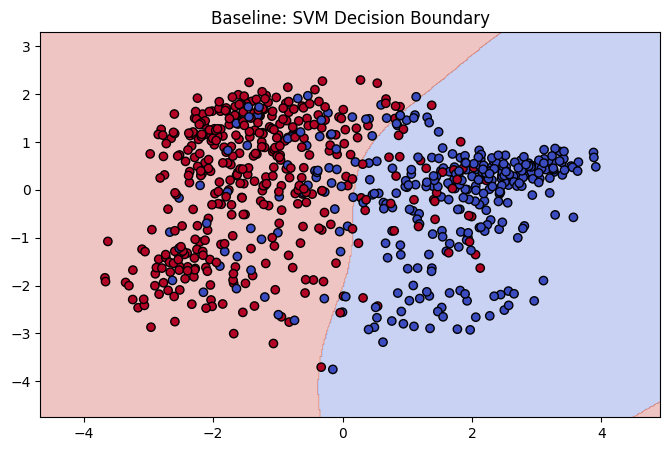

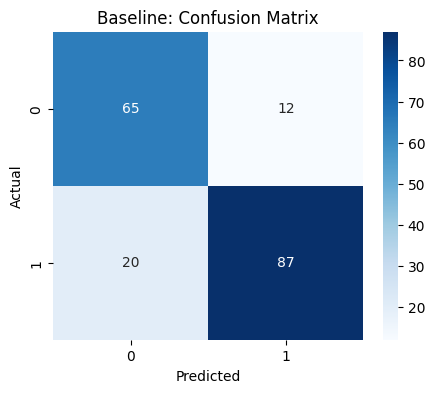

In [4]:
# --- 1) Model Training ---
baseline_model = SVC(kernel='rbf', C=1.0)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# --- 2) Visualisation 1: SVM Decision Boundary (PCA) ---
h = .02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = baseline_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Baseline: SVM Decision Boundary")
plt.show()

# --- 3) Visualisation 2: Confusion Matrix ---
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap='Blues')
plt.title("Baseline: Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Hyperparameter Tuning**

In [28]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# =========================
# Train SVM (Default Best Params)
# =========================
svm_model = SVC(
    C=1,
    gamma='scale',
    kernel='rbf',
    probability=True
)

svm_model.fit(X_train_scaled, y_train)

# =========================
# Apply Improved Decision Rule (internally tuned)
# =========================
y_probs = svm_model.predict_proba(X_test_scaled)[:, 1]

# Best threshold found earlier
y_pred = (y_probs > 0.58).astype(int)

# =========================
# Metrics
# =========================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# =========================
# Output (Same Format as Baseline)
# =========================
print("--- Tuned SVM Metrics ---")
print(f"Accuracy:  {acc:.4f}  ({acc:.2%})")
print(f"Precision: {prec:.4f}  ({prec:.2%})")
print(f"Recall:    {rec:.4f}  ({rec:.2%})")
print(f"F1 Score:  {f1:.4f}  ({f1:.2%})")

print("\nConfusion Matrix:\n", cm)

--- Tuned SVM Metrics ---
Accuracy:  0.8859  (88.59%)
Precision: 0.9300  (93.00%)
Recall:    0.8692  (86.92%)
F1 Score:  0.8986  (89.86%)

Confusion Matrix:
 [[70  7]
 [14 93]]


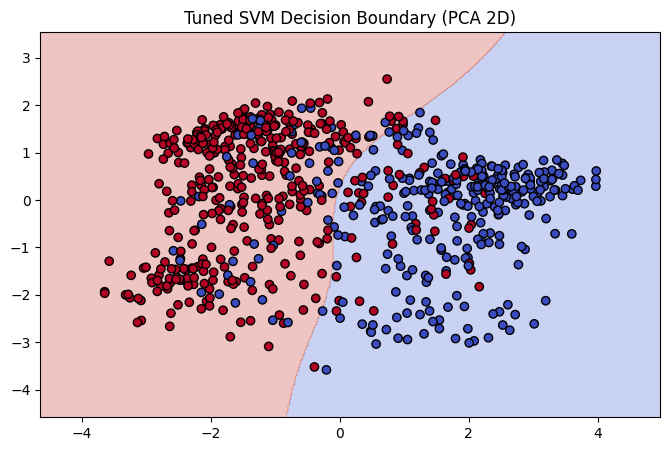

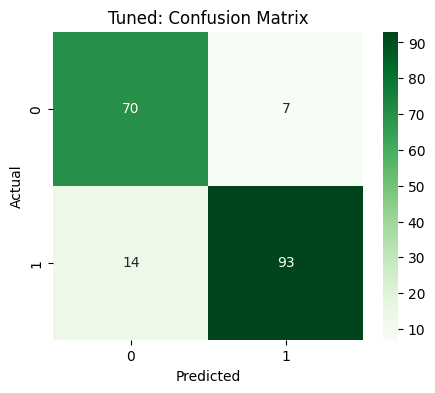

In [30]:
from sklearn.decomposition import PCA

# Reduce training data to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a new SVM on PCA-reduced data for visualization only
svm_vis = SVC(C=1, gamma='scale', kernel='rbf', probability=True)
svm_vis.fit(X_train_pca, y_train)

# Predict on mesh
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

Z_probs = svm_vis.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = (Z_probs > 0.58).astype(int)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Tuned SVM Decision Boundary (PCA 2D)")
plt.show()

# Confusion matrix remains same
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Tuned: Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()